In [1]:
## import packages
from catboost import CatBoostClassifier, Pool
import numpy as np
import pandas as pd
import polars as pl
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.simplefilter('ignore')


In [2]:
## load data
train = pl.read_csv('train.csv')
test = pl.read_csv('test.csv')
test = test.with_columns(pl.lit(0).cast(pl.Int64).alias('Response'))


In [3]:
## prepare data
df = pl.concat([train, test])

df = df.with_columns([
    pl.col('Gender').replace({'Male': 0, 'Female': 1}).cast(pl.Int32),
    pl.col('Region_Code').cast(int),
    pl.col('Vehicle_Age').replace({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}).cast(pl.Int32),
    pl.col('Vehicle_Damage').replace({'No': 0, 'Yes': 1}).cast(pl.Int32),
    pl.col('Annual_Premium').cast(int),
    pl.col('Policy_Sales_Channel').cast(int)
])

df = df.with_columns([
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Annual_Premium'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Annual_Premium'),
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Vehicle_Age'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Vehicle_Age'),
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Vehicle_Damage'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Vehicle_Damage'),
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Vintage'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Vintage')
])

# def combine_columns_with_factorize(data_input):
#     df_c = data_input.clone()
#     combinations = [
#         ["Previously_Insured", "Vehicle_Damage"],
#         ["Previously_Insured", "Vehicle_Age"],
#         ["Previously_Insured", "Annual_Premium"],
#         ["Previously_Insured", "Policy_Sales_Channel"],
#         ["Driving_License", "Previously_Insured"],
#         ["Driving_License", "Vehicle_Damage"],
#         ["Vehicle_Age", "Vehicle_Damage"],
#         ["Gender", "Previously_Insured"],
#         ["Gender", "Vehicle_Damage"],
#         ["Vehicle_Damage", "Annual_Premium"],
#         ["Driving_License", "Vehicle_Age"],
#         ["Vehicle_Damage", "Policy_Sales_Channel"],
#         ["Gender", "Driving_License"],
#         ["Vehicle_Age", "Policy_Sales_Channel"]
#     ]

#     for c in combinations:
#         col_name = c[0] + "_" + c[1]
#         combined_series = (df_c[c[0]].cast(pl.Utf8) + df_c[c[1]].cast(pl.Utf8)).to_pandas()
#         factorized_values = pd.factorize(combined_series)[0]
#         df_c = df_c.with_columns(pl.Series(factorized_values).alias(col_name))
#     return df_c
# df=combine_columns_with_factorize(df)


train = df[:train.shape[0]].to_pandas()
test = df[train.shape[0]:].to_pandas()

train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Previously_Insured_Annual_Premium,Previously_Insured_Vehicle_Age,Previously_Insured_Vehicle_Damage,Previously_Insured_Vintage
0,0,0,21,1,35,0,1,1,65101,124,187,0,0,0,0,0
1,1,0,43,1,28,0,2,1,58911,26,288,1,1,1,0,1
2,2,1,25,1,14,1,0,0,38043,152,254,0,2,2,1,2
3,3,1,35,1,1,0,1,1,2630,156,76,0,3,0,0,3
4,4,1,36,1,15,1,1,0,31951,152,294,0,4,3,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,0,48,1,6,0,1,1,27412,26,218,0,5210,0,0,144
11504794,11504794,1,26,1,36,0,0,1,29509,152,115,1,23274,4,0,176
11504795,11504795,1,29,1,32,1,0,0,2630,152,189,0,18,2,1,456
11504796,11504796,1,51,1,28,0,1,1,48443,26,274,1,14121,0,0,124


In [4]:
#pd.factorize((
df['Previously_Insured'].cast(str) + df['Annual_Premium'].cast(str)
#).to_numpy())[0]

Previously_Insured
str
"""065101"""
"""058911"""
"""138043"""
"""02630"""
"""131951"""
…
"""051661"""
"""125651"""
"""12630"""


In [5]:
X=train[[c for c in train.columns if c not in ['id', 'Response']]]
y=train['Response']
X_test = test[X.columns]

In [6]:
## train model
aucs = []
preds = []

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(skf.split(X,y)):
    print(f'### Fold {fold+1} Training ###')

    X_train = X.loc[train_idx]
    y_train = y.loc[train_idx]
    X_valid = X.loc[valid_idx]
    y_valid = y.loc[valid_idx]
    

    X_train_pool = Pool(X_train, y_train, cat_features=X_train.columns.values)
    X_valid_pool = Pool(X_valid, y_valid, cat_features=X_valid.columns.values)
    X_test_pool = Pool(X_test, cat_features=X_test.columns.values)
    model = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        learning_rate=0.1,
        iterations=5000,
        depth=9,
        random_strength=0,
        l2_leaf_reg=0.5,
        task_type='GPU',
        random_seed=42,
        verbose=False
    )

    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=1000, early_stopping_rounds=200)

    pred_valid = model.predict_proba(X_valid_pool)[:, 1]
    preds.append(model.predict_proba(X_test_pool)[:, 1])

    auc = roc_auc_score(y_valid, pred_valid)
    aucs.append(auc)

    print(f'Fold {fold+1} AUC: {auc:.5f}\n')

print(f'\nOverall AUC: {np.mean(aucs):.5f} +/- {np.std(aucs):.5f}')


### Fold 1 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8754181	best: 0.8754181 (0)	total: 710ms	remaining: 59m 10s
1000:	test: 0.8934859	best: 0.8934868 (983)	total: 11m 45s	remaining: 46m 58s
bestTest = 0.893507123
bestIteration = 1315
Shrink model to first 1316 iterations.
Fold 1 AUC: 0.89351

### Fold 2 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8757215	best: 0.8757215 (0)	total: 648ms	remaining: 54m 1s
1000:	test: 0.8938394	best: 0.8938401 (998)	total: 11m 44s	remaining: 46m 55s
bestTest = 0.8938601613
bestIteration = 1270
Shrink model to first 1271 iterations.
Fold 2 AUC: 0.89386


Overall AUC: 0.89368 +/- 0.00018


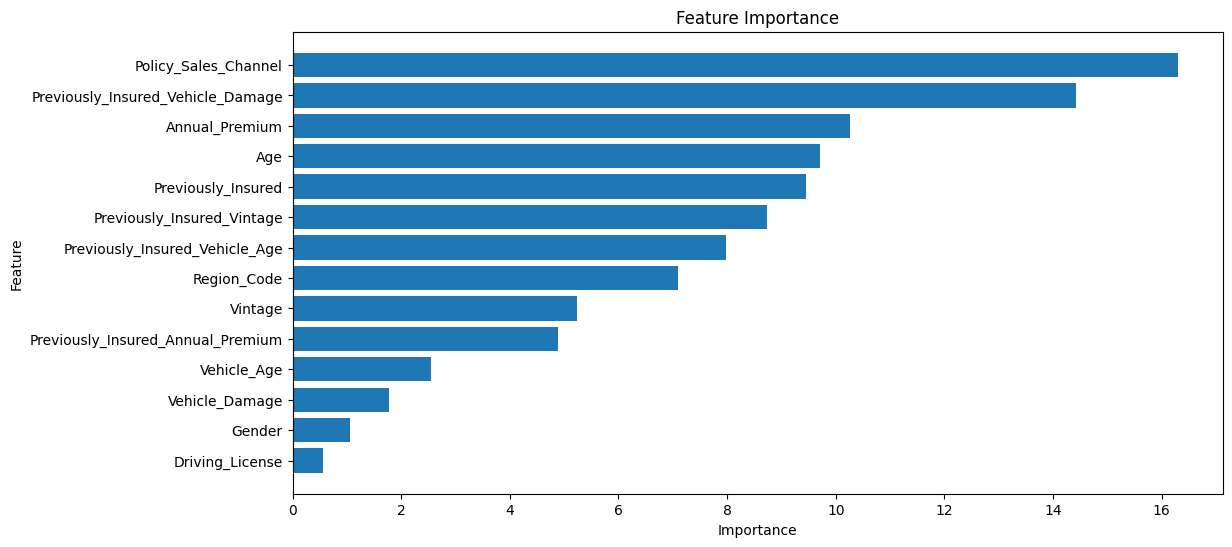

In [7]:
import matplotlib.pyplot as plt
# 特徴量の重要度の取得
feature_importances = model.get_feature_importance(type='FeatureImportance')
feature_names = X.columns
# 特徴量の重要度をデータフレームに変換
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values("Importance",ascending=False)
# 特徴量の重要度を表示
plt.figure(figsize=(12, 6))
plt.title('Feature Importance')
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()
# 平均精度の表示

In [8]:
## create submission
submission = test[['id']]
submission['Response'] = np.mean(preds, axis=0)

submission.to_csv('submission_1stplace_sol_baseline.csv', index=False)
submission

,id,Response
0,11504798,0.005782
1,11504799,0.688336
2,11504800,0.236542
3,11504801,0.000094
4,11504802,0.237005
...,...,...
7669861,19174659,0.192726
7669862,19174660,0.000087
7669863,19174661,0.000460
7669864,19174662,0.610468
